## Training a Classifier using CIFAR-10 Dataset

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings("ignore")

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


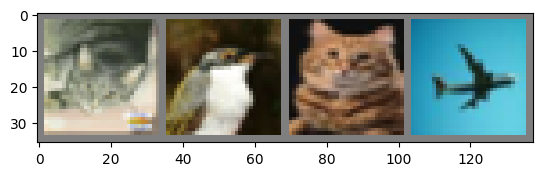

cat   bird  cat   plane


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

### Define a Convolutional Neural Network

In [32]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120) # 5*5 from image dimension
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # conv1 -> relu -> pool 
        x = self.pool(F.relu(self.conv2(x))) # conv2 -> relu -> pool
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # fc1 -> relu
        x = F.relu(self.fc2(x)) # fc2 -> relu
        x = self.fc3(x)
        return x
    
net = Net()

Loss Function: Cross-Entropy Loss<br>
Optimizer: Stochastic Gradient Descent

In [33]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # SGD with momentum

## Train the Network

In [34]:
EPOCH = 2

for epoch in range(EPOCH):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%2000 == 1999:
            print(f"[{epoch+1}, {i+1:5d}] loss: {running_loss/2000:.3f}")
            running_loss = 0.0
print("Finished Training")

[1,  2000] loss: 2.265
[1,  4000] loss: 1.886
[1,  6000] loss: 1.717
[1,  8000] loss: 1.608
[1, 10000] loss: 1.534
[1, 12000] loss: 1.490
[2,  2000] loss: 1.436
[2,  4000] loss: 1.405
[2,  6000] loss: 1.380
[2,  8000] loss: 1.380
[2, 10000] loss: 1.338
[2, 12000] loss: 1.317
Finished Training


Save the model


In [35]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Test the network on test data

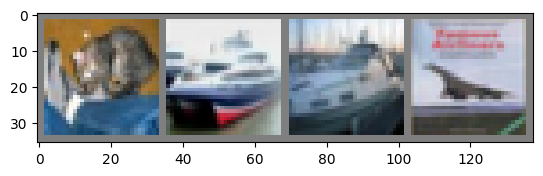

Ground Truth:  cat   ship  ship  plane


In [36]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print("Ground Truth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

Loading the Saved Model

In [37]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [38]:
outputs = net(images)

In [39]:
_, predicted = torch.max(outputs, 1)
print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(batch_size)))

Predicted:  cat   car   car   plane


In [40]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
print(f"Accuracy of the network on the 10000 test images: {100*correct/total:.2f}%")

Accuracy of the network on the 10000 test images: 53.50%


In [41]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class {classname:5s} is: {accuracy:.1f}%")

Accuracy for class plane is: 65.4%
Accuracy for class car   is: 76.5%
Accuracy for class bird  is: 38.0%
Accuracy for class cat   is: 53.3%
Accuracy for class deer  is: 44.7%
Accuracy for class dog   is: 20.8%
Accuracy for class frog  is: 60.9%
Accuracy for class horse is: 52.2%
Accuracy for class ship  is: 69.9%
Accuracy for class truck is: 53.3%
